In [99]:
from pykrx import stock
import datetime
import pandas as pd
import math
from tqdm import tqdm
from gensim.models import word2vec
import random
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import numpy as np
import plotly.express as px
from statsmodels.graphics.mosaicplot import mosaic
matplotlib.rcParams['axes.unicode_minus'] = False
from matplotlib import rc 
%matplotlib inline
rc('font', family='Malgun Gothic')

In [2]:
data_1 = pd.read_csv('LPOINT_BIG_COMP_01_DEMO.csv')
data_2 = pd.read_csv('LPOINT_BIG_COMP_02_PDDE.csv')
data_3 = pd.read_csv('LPOINT_BIG_COMP_03_COP_U.csv')
data_4 = pd.read_csv('LPOINT_BIG_COMP_04_PD_CLAC.csv')
data_5 = pd.read_csv('LPOINT_BIG_COMP_05_BR.csv')
data_6 = pd.read_csv('LPOINT_BIG_COMP_06_LPAY.csv')

C:\Users\User\AppData\Local\Temp\ipykernel_16020\2691005760.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  data_2 = pd.read_csv('LPOINT_BIG_COMP_02_PDDE.csv')


## 전처리

### data_6

In [3]:
data_61=data_6.groupby("cust")["cop_c"].agg(**{'most_cop':lambda x:x.mode()[0]})
data_62=data_6.groupby("cust")["chnl_dv"].agg(**{'most_chnl':lambda x:x.mode()[0]})
data_63=data_6.groupby("cust")["buy_am"].agg(**{'point_sum':"sum"})
data_64=data_6.groupby("cust")["buy_am"].agg(**{'point_count':"count"})

In [4]:
data_6_f = pd.concat([data_61, data_62, data_63, data_64], axis=1).reset_index()

In [5]:
data_6_f.head()

,cust,most_cop,most_chnl,point_sum,point_count
0,M000136117,A06,2,1137501,4
1,M000419293,L01,2,3528701,42
2,M000494848,L01,2,4599615,94
3,M000557840,A02,1,1593340,38
4,M000871427,C01,1,48700,5


### data_2,3 결측치 처리
- br_c NaN값은 온라인이므로 Nan값을 온라인으로 처리

In [6]:
data_2 = data_2.fillna('온라인')
data_3 = data_3.fillna('온라인')

### data_1,4,5는 마스터 테이블 개념으로 다른 데이터에 병합가능

#### 1) data_2에 pd_c를 기준으로 data_4에 있는 정보를 추가

In [7]:
data_2 = pd.merge(data_2, data_4, how='left',on='pd_c')
data_2.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,pd_nm,clac_hlv_nm,clac_mcls_nm
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1,남성티셔츠,남성의류,남성의류상의
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700.0,1,기타주방일회용품,주방잡화,주방일회용품
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1,남성티셔츠,남성의류,남성의류상의
3,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1,남성티셔츠,남성의류,남성의류상의
4,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1,남성티셔츠,남성의류,남성의류상의


#### 2-1) data_2에 br_c 기준으로 data_5에 있는 정보를 추가

In [8]:
data_2 = pd.merge(data_2, data_5[data_5.columns.difference(['cop_c'])], how='left',on='br_c')
data_2.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,pd_nm,clac_hlv_nm,clac_mcls_nm,zon_hlv,zon_mcls
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1,남성티셔츠,남성의류,남성의류상의,Z10,Z10042
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700.0,1,기타주방일회용품,주방잡화,주방일회용품,Z13,Z13001
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1,남성티셔츠,남성의류,남성의류상의,Z10,Z10042
3,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1,남성티셔츠,남성의류,남성의류상의,Z10,Z10042
4,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1,남성티셔츠,남성의류,남성의류상의,Z10,Z10042


#### 2-2) data_3에 br_c 기준으로 data_5에 있는 정보를 추가

In [9]:
data_3 = pd.merge(data_3, data_5[data_5.columns.difference(['cop_c'])], how='left',on='br_c')
data_3.head()

,cust,rct_no,cop_c,br_c,chnl_dv,de_dt,vst_dt,de_hr,buy_am,zon_hlv,zon_mcls
0,M839993508,21102612B015763935,B01,B010012,1,20211026,20211026,12,60000,Z17,Z17024
1,M839993508,21110610B014219744,B01,B010012,1,20211106,20211106,10,17100,Z17,Z17024
2,M839993508,21021112B013419710,B01,B010012,1,20210211,20210211,12,136500,Z17,Z17024
3,M839993508,21092010B012637545,B01,B010012,1,20210920,20210920,10,34200,Z17,Z17024
4,M839993508,21101009D015920171,D01,D010614,1,20211010,20211010,9,2500,Z17,Z17018


#### 3-1) data_2에 cust 기준으로 data_1에 있는 정보를 추가

In [10]:
data_2 = pd.merge(data_2.drop(columns='zon_hlv'), data_1, how='left',on='cust')
data_2.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,pd_nm,clac_hlv_nm,clac_mcls_nm,zon_mcls,ma_fem_dv,ages,zon_hlv
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1,남성티셔츠,남성의류,남성의류상의,Z10042,여성,50대,Z17
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700.0,1,기타주방일회용품,주방잡화,주방일회용품,Z13001,여성,40대,Z13
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1,남성티셔츠,남성의류,남성의류상의,Z10042,여성,50대,Z17
3,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1,남성티셔츠,남성의류,남성의류상의,Z10042,여성,50대,Z17
4,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1,남성티셔츠,남성의류,남성의류상의,Z10042,여성,50대,Z17


#### 3-2) data_3에 cust 기준으로 data_1에 있는 정보를 추가

In [11]:
data_3 = pd.merge(data_3.drop(columns='zon_hlv'), data_1, how='left',on='cust')
data_3.head()

,cust,rct_no,cop_c,br_c,chnl_dv,de_dt,vst_dt,de_hr,buy_am,zon_mcls,ma_fem_dv,ages,zon_hlv
0,M839993508,21102612B015763935,B01,B010012,1,20211026,20211026,12,60000,Z17024,남성,70대,Z17
1,M839993508,21110610B014219744,B01,B010012,1,20211106,20211106,10,17100,Z17024,남성,70대,Z17
2,M839993508,21021112B013419710,B01,B010012,1,20210211,20210211,12,136500,Z17024,남성,70대,Z17
3,M839993508,21092010B012637545,B01,B010012,1,20210920,20210920,10,34200,Z17024,남성,70대,Z17
4,M839993508,21101009D015920171,D01,D010614,1,20211010,20211010,9,2500,Z17018,남성,70대,Z17


#### 3-3) data_6에 cust 기준으로 data_1에 있는 정보를 추가

In [12]:
data_6 = pd.merge(data_6, data_1, how='left',on='cust')
data_6.head()

,cust,rct_no,cop_c,chnl_dv,de_dt,de_hr,buy_am,ma_fem_dv,ages,zon_hlv
0,M629656521,210803210311226,A03,1,20210803,21,10900,남성,40대,Z04
1,M216016456,210803130167542,L01,2,20210803,13,6860,여성,40대,Z04
2,M205142844,210803140275112,A02,1,20210803,14,9000,여성,60대,Z17
3,M737010483,210803040637594,A06,2,20210803,4,36740,남성,40대,Z16
4,M707775545,210803140675502,A06,2,20210803,14,138500,남성,30대,Z11


### data_2,3,6에 data_1,4,5정보를 넣었으므로 data_2,3,6으로만 진행

In [13]:
data_2 = data_2.fillna('없음')
data_3 = data_3.fillna('없음')

### 2번데이터 중복값 합치기
- 중복데이터는 같은상품을 여러번 구매를 했거나 하는 등 중복된 건은 중복된 이유가 있습니다. 
- 완전히 상품단위로 제공되는 데이터가 아니기 때문에 일정 카테고리 단위로 데이터를 통일시킨 거라 중복된 건은 원래 중복된 데이터가맞습니다.
- 따라서 중복데이터를 그냥 제거하는것이 아닌 buy_am, buy_ct에는 중복된 값을 더하고 나머지는 제거

In [14]:
data_2["dup"] = np.ones(len(data_2))
dup = data_2.groupby(['cust', 'rct_no', 'chnl_dv', 'cop_c', 'br_c', 'pd_c', 'de_dt', 'de_hr',
       'buy_am', 'buy_ct', 'pd_nm', 'clac_hlv_nm', 'clac_mcls_nm', 'zon_mcls',
       'ma_fem_dv', 'ages', 'zon_hlv'])["dup"].sum()
dup = pd.DataFrame(dup).reset_index()
data_2 = pd.merge(data_2, dup, on = ['cust', 'rct_no', 'chnl_dv', 'cop_c', 'br_c', 'pd_c', 'de_dt', 'de_hr',
       'buy_am', 'buy_ct', 'pd_nm', 'clac_hlv_nm', 'clac_mcls_nm', 'zon_mcls',
       'ma_fem_dv', 'ages', 'zon_hlv'])
data_2["buy_am"] = data_2["buy_am"]*data_2["dup_y"]
data_2["buy_ct"] = data_2["buy_ct"]*data_2["dup_y"]
del data_2["dup_x"]
data_2.rename(columns={"dup_y":"중복수"}, inplace=True)
data_2 = data_2.drop_duplicates()
data_2 = data_2.reset_index(drop = True)

In [15]:
np.shape(data_2)

(4144389, 18)

In [16]:
data_2.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,pd_nm,clac_hlv_nm,clac_mcls_nm,zon_mcls,ma_fem_dv,ages,zon_hlv,중복수
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1.0,남성티셔츠,남성의류,남성의류상의,Z10042,여성,50대,Z17,1.0
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700.0,1.0,기타주방일회용품,주방잡화,주방일회용품,Z13001,여성,40대,Z13,1.0
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,38000.0,2.0,남성티셔츠,남성의류,남성의류상의,Z10042,여성,50대,Z17,2.0
3,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,남성티셔츠,남성의류,남성의류상의,Z10042,여성,50대,Z17,1.0
4,M430112881,A01000005297,1,A01,A010039,PD1692,20210101,10,9900.0,1.0,커피/음료,테넌트/음식점,식당,Z10042,여성,50대,Z17,1.0


## 지역별

- 지역 데이터를 활용하여 수도권, 비수도권 구분

In [17]:
pd.DataFrame(data_2.groupby('zon_hlv').cust.count()).sort_values('cust', ascending=False).head()

,cust
zon_hlv,
Z17,1184096
Z10,1099778
Z16,329074
Z04,266889
Z11,266787


In [18]:
pd.DataFrame(data_3.groupby('zon_hlv').cust.count()).sort_values('cust', ascending=False).head()

,cust
zon_hlv,
Z17,81259
Z10,64380
Z16,22857
Z11,14125
Z04,13791


In [19]:
pd.DataFrame(data_6.groupby('zon_hlv').cust.count()).sort_values('cust', ascending=False).head()

,cust
zon_hlv,
Z17,133360
Z10,90343
Z16,32853
Z04,18164
Z11,16254


In [20]:
data_2_eda = data_2.copy()
Metro_lst = ['Z10', 'Z17']
data_2_eda["zon_hlv"]=data_2_eda["zon_hlv"].apply(lambda x: '수도권' if x in Metro_lst else '비수도권')
data_2_eda = pd.DataFrame(data_2_eda.groupby('zon_hlv')['buy_am'].sum()/data_2_eda.groupby('zon_hlv')['buy_ct'].sum())
data_2["city"]=data_2["zon_hlv"].apply(lambda x: 1 if x in Metro_lst else 0)
data_2_eda.columns = ['평균구매금액']
data_2_eda

,평균구매금액
zon_hlv,
비수도권,16834.774209
수도권,18448.961961


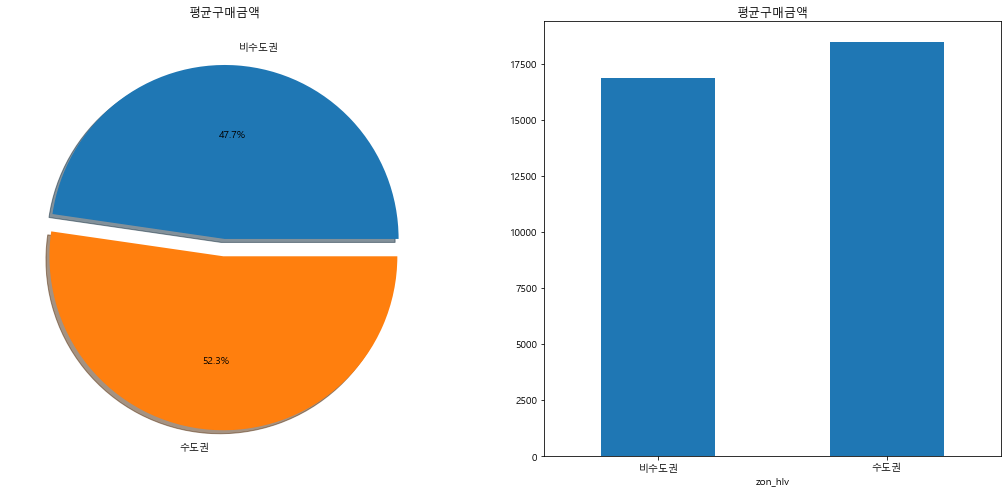

In [21]:
df3 = data_2_eda.평균구매금액
f,ax=plt.subplots(1,2,figsize=(18,8))
df3.plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('평균구매금액')
ax[0].set_ylabel('')
data_2_eda['평균구매금액'].plot(kind='bar', rot=0)
ax[1].set_title('평균구매금액')
plt.show()

In [22]:
del data_2_eda

In [23]:
Metro_lst=["Z17", "Z10"]

In [24]:
data_2["city"]=data_2["zon_hlv"].apply(lambda x: 1 if x in Metro_lst else 0)

#### Z17, Z10은 경기도 및 서울일 가능성이 높음 / Z02, Z07은 세종,제주일 가능성이 높음
#### Z17 경기, Z10 서울 Z16 부산으로 예상 Z02는 세종, Z07은 제주로 예상
#### Z17,Z10은 수도권이 확실하므로 외부 인구수 공공데이터를 활용하여 수도권 비수도권여부 피처 생성

## 공휴일

- 2021년 법정 공휴일 구분

In [25]:
import holidays
start_date='20210101'
end_date='20211231'
date_list=pd.date_range(start=start_date, end=end_date, freq='D')

In [26]:
kr_holidays = holidays.KR()

In [27]:
holiday_df = pd.DataFrame(columns=['de_dt','holiday'])
holiday_df['de_dt'] = sorted(date_list)
holiday_df['holiday'] = holiday_df.de_dt.apply(lambda x: 1 if x in kr_holidays else 0)

In [28]:
data_2["de_dt"]=pd.to_datetime(data_2["de_dt"].astype("str"))

In [29]:
holiday_df.head()
data_2=pd.merge(data_2, holiday_df, how="left")

In [30]:
data_2_holi = data_2.copy()
data_2_holi = pd.DataFrame(data_2_holi.groupby('holiday')['buy_am'].sum()/data_2_holi.groupby('holiday')['buy_ct'].sum())
data_2_holi.set_index([['비공휴일','공휴일']], inplace=True)
data_2_holi.columns = ['평균구매금액']
data_2_holi

,평균구매금액
비공휴일,17641.062530
공휴일,18888.348665


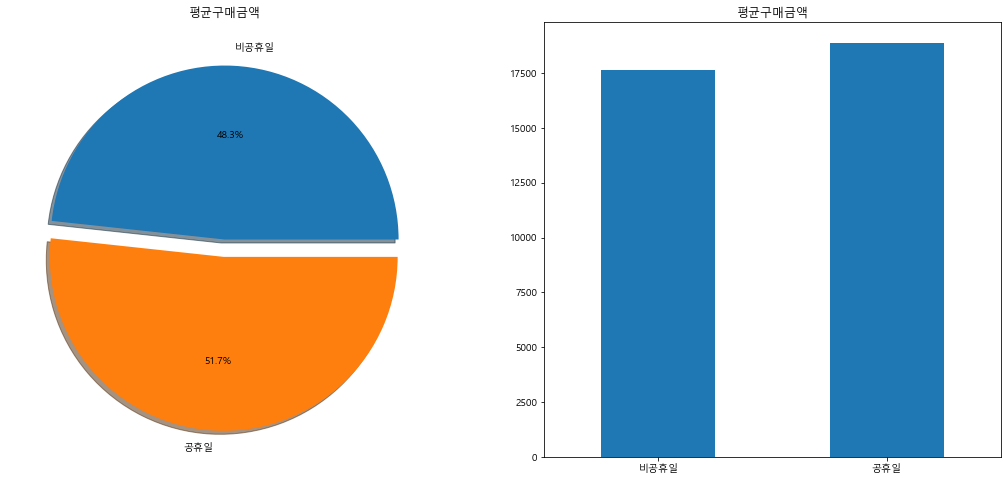

In [31]:
df3 = data_2_holi.평균구매금액
f,ax=plt.subplots(1,2,figsize=(18,8))
df3.plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('평균구매금액')
ax[0].set_ylabel('')
data_2_holi['평균구매금액'].plot(kind='bar', rot=0)
ax[1].set_title('평균구매금액')
plt.show()

## 주식 데이터 이용, 출처 : 네이버 금융

- 날짜 별 코스피 지수 및 롯데 지주 주가

In [32]:
kospi=stock.get_index_fundamental("20201230", "20211231","1001")[["종가", "등락률"]].reset_index()
lotte=stock.get_market_ohlcv_by_date("20201230", "20211231","004990")[["종가", "거래량"]].reset_index()

In [33]:
kospi.rename(columns={"날짜":"de_dt","종가":"종가_kospi","등락률":"등락률_kospi"}, inplace=True)
lotte.rename(columns={"날짜":"de_dt", "종가":"종가_lotte","거래량":"거래량_lotte"}, inplace=True)

In [34]:
kospi["de_dt"]=kospi["de_dt"].apply(lambda x: x + datetime.timedelta(days=1))
lotte["de_dt"]=kospi["de_dt"].apply(lambda x: x + datetime.timedelta(days=1))

In [35]:
start_date='20201230'
end_date='20211231'
date_list=pd.date_range(start=start_date, end=end_date, freq='D')
jusik=pd.DataFrame({"de_dt":date_list})
jusik=pd.merge(pd.merge(jusik,kospi,how="left"),lotte,how="left")

In [36]:
jusik["등락률_kospi"].fillna(0,inplace=True)
jusik.fillna(method="ffill",inplace=True)
jusik=jusik.iloc[2:,:]
jusik.head()

,de_dt,종가_kospi,등락률_kospi,종가_lotte,거래량_lotte
2,2021-01-01,2873.47,0.00,35300.0,236970.0
3,2021-01-02,2873.47,0.00,35300.0,236970.0
4,2021-01-03,2873.47,0.00,35300.0,236970.0
5,2021-01-04,2873.47,0.00,35300.0,236970.0
6,2021-01-05,2944.45,2.47,35300.0,236970.0


In [37]:
data_2=pd.merge(data_2, jusik, on="de_dt",  how="left")
data_2.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,...,ma_fem_dv,ages,zon_hlv,중복수,city,holiday,종가_kospi,등락률_kospi,종가_lotte,거래량_lotte
0,M430112881,A01000001113,1,A01,A010039,PD0290,2021-01-01,10,15000.0,1.0,...,여성,50대,Z17,1.0,1,1,2873.47,0.0,35300.0,236970.0
1,M646853852,A01000002265,1,A01,A010025,PD1369,2021-01-01,10,79700.0,1.0,...,여성,40대,Z13,1.0,0,1,2873.47,0.0,35300.0,236970.0
2,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,38000.0,2.0,...,여성,50대,Z17,2.0,1,1,2873.47,0.0,35300.0,236970.0
3,M430112881,A01000004946,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1.0,...,여성,50대,Z17,1.0,1,1,2873.47,0.0,35300.0,236970.0
4,M430112881,A01000005297,1,A01,A010039,PD1692,2021-01-01,10,9900.0,1.0,...,여성,50대,Z17,1.0,1,1,2873.47,0.0,35300.0,236970.0


In [38]:
df_buy_ct = pd.DataFrame(data_2.groupby('de_dt')['cust'].nunique())
df_buy_am = pd.DataFrame(data_2.groupby('de_dt')['buy_am'].sum())
df_buy_am = df_buy_am.buy_am / df_buy_ct.cust
df_buy = pd.concat([df_buy_ct, df_buy_am], axis = 1)
df_buy.columns = ['고객수', '평균구매금액']

In [39]:
jusik = jusik.reset_index(drop = True)
df_buy = df_buy.reset_index(drop = True)
jusik_buy = pd.concat([jusik, df_buy], axis = 1)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


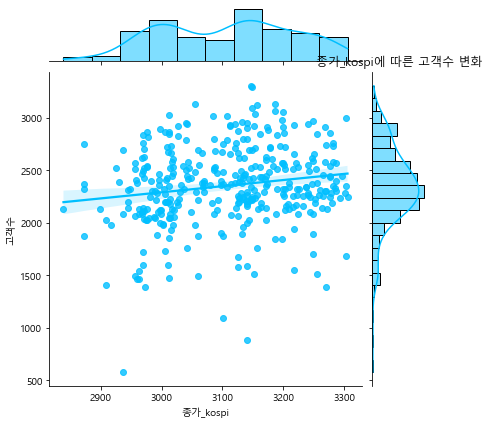

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


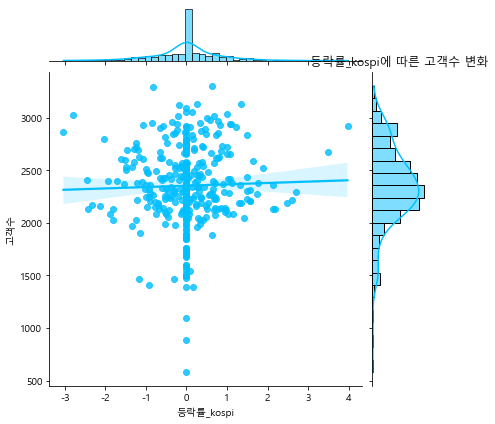

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


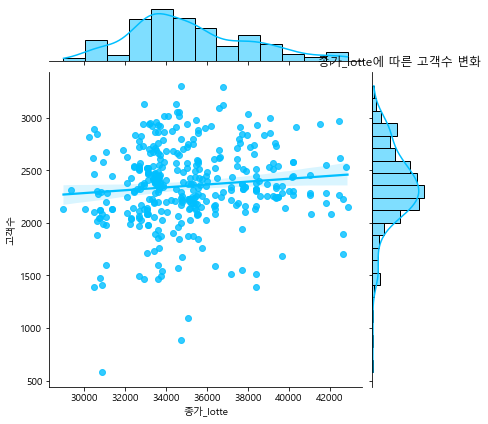

In [40]:
for jong in ["종가_kospi", "등락률_kospi", "종가_lotte"]:
    sns.jointplot(jong, "고객수", height=6, data=jusik_buy, kind="reg", color ="deepskyblue")
    plt.title(jong + "에 따른 고객수 변화")
    plt.show()

In [41]:
jusik_buy=jusik_buy.query("거래량_lotte<1000000")

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


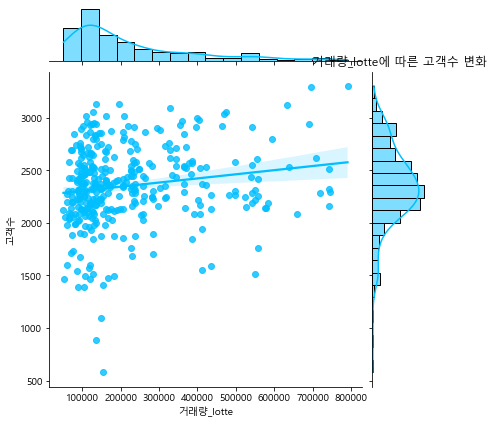

In [42]:
for jong in ["거래량_lotte"]:
    sns.jointplot(jong, "고객수", height=6, data=jusik_buy, kind="reg", color ="deepskyblue")
    plt.title(jong + "에 따른 고객수 변화")
    plt.show()

## 날씨 데이터 출처 : 기상청

- 날짜 별 기온 및 강수량

In [43]:
temp=pd.read_csv("기상청_2021일자별 기온(출처_기상청_기상자료개방포털.csv", encoding="euc-kr")
precp=pd.read_csv("기상청_2021일자별_강수량(출처_기상청_기상자료개방포털).csv", encoding="euc-kr")

In [44]:
gisang=pd.merge(temp[["날짜","평균기온(℃)", "최저기온(℃)", "최고기온(℃)"]],precp[["날짜","강수량(mm)"]])
gisang

,날짜,평균기온(℃),최저기온(℃),최고기온(℃),강수량(mm)
0,2021-01-01,-3.4,-9.3,1.6,0.2
1,2021-01-02,-2.8,-6.9,1.4,0.0
2,2021-01-03,-3.3,-7.7,1.1,0.0
3,2021-01-04,-2.0,-8.1,3.9,0.0
4,2021-01-05,-2.2,-7.4,1.9,0.1
...,...,...,...,...,...
360,2021-12-27,-4.6,-11.2,0.5,0.1
361,2021-12-28,0.0,-5.2,4.9,0.0
362,2021-12-29,2.5,-2.5,7.5,0.1
363,2021-12-30,-0.7,-3.3,2.7,0.4


In [45]:
gisang["날짜"]=pd.to_datetime(gisang["날짜"].astype("str"))
gisang.rename(columns={"날짜":"de_dt"}, inplace=True)
data_2=pd.merge(data_2,gisang,on="de_dt", how="left")

## 문제 정의 시각화 및 외부 데이터 시각화

- 문제 정의

In [46]:
data_2["month"]=data_2["de_dt"].dt.month

In [47]:
nu_m=pd.DataFrame(data_2.groupby("cust")["month"].nunique())

In [48]:
data_2

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,...,holiday,종가_kospi,등락률_kospi,종가_lotte,거래량_lotte,평균기온(℃),최저기온(℃),최고기온(℃),강수량(mm),month
0,M430112881,A01000001113,1,A01,A010039,PD0290,2021-01-01,10,15000.0,1.0,...,1,2873.47,0.00,35300.0,236970.0,-3.4,-9.3,1.6,0.2,1
1,M646853852,A01000002265,1,A01,A010025,PD1369,2021-01-01,10,79700.0,1.0,...,1,2873.47,0.00,35300.0,236970.0,-3.4,-9.3,1.6,0.2,1
2,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,38000.0,2.0,...,1,2873.47,0.00,35300.0,236970.0,-3.4,-9.3,1.6,0.2,1
3,M430112881,A01000004946,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1.0,...,1,2873.47,0.00,35300.0,236970.0,-3.4,-9.3,1.6,0.2,1
4,M430112881,A01000005297,1,A01,A010039,PD1692,2021-01-01,10,9900.0,1.0,...,1,2873.47,0.00,35300.0,236970.0,-3.4,-9.3,1.6,0.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4144384,M816318679,E06052115831,2,A06,온라인,PD0507,2021-12-31,22,50000.0,1.0,...,0,2977.65,-0.52,30250.0,208990.0,-3.9,-7.2,0.1,0.0,12
4144385,M816318679,E06052116037,2,A06,온라인,PD0507,2021-12-31,22,30000.0,3.0,...,0,2977.65,-0.52,30250.0,208990.0,-3.9,-7.2,0.1,0.0,12
4144386,M182645944,E06052117103,2,A06,온라인,PD0294,2021-12-31,23,289000.0,1.0,...,0,2977.65,-0.52,30250.0,208990.0,-3.9,-7.2,0.1,0.0,12
4144387,M533286446,E06052118403,2,A06,온라인,PD0507,2021-12-31,23,1000000.0,5.0,...,0,2977.65,-0.52,30250.0,208990.0,-3.9,-7.2,0.1,0.0,12


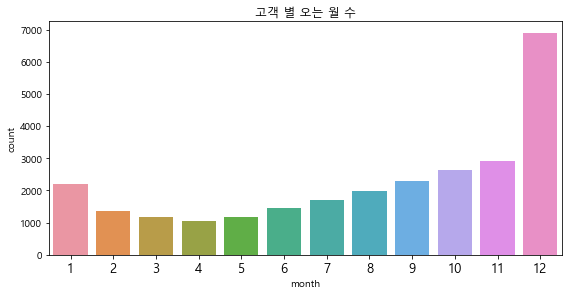

In [49]:
plt.figure(figsize=(8,4))
ax=sns.countplot(x="month", data=nu_m)
ax.set_xticklabels(ax.get_xticklabels(),  fontsize=13)
plt.tight_layout()
plt.title("고객 별 오는 월 수")
plt.show()

In [50]:
nu_m["m_group"]=nu_m["month"].apply(lambda x: "A" if x < 4 else("B" if x< 10 else "C"))

In [51]:
hi=nu_m.groupby("m_group")["month"].count().reset_index()
group_name = hi[hi.columns[0]]
group_size = hi[hi.columns[1]]
hi

,m_group,month
0,A,4752
1,B,9703
2,C,12462


In [52]:
bye=nu_m.groupby("month")["m_group"].count().reset_index()
bye["group"]=["A"]*3+["B"]*6+["C"]*3
subgroup_name = bye[bye.columns[0]]
subgroup_size = bye[bye.columns[1]]
tmp_subgroup_name = bye[bye.columns[2]]
bye

,month,m_group,group
0,1,2188,A
1,2,1376,A
2,3,1188,A
3,4,1062,B
4,5,1188,B
5,6,1468,B
6,7,1701,B
7,8,1984,B
8,9,2300,B
9,10,2635,C


In [53]:
zero_box = np.zeros(len(group_name))
for i in range(len(group_name)):
    for j in tmp_subgroup_name:
        if j == group_name[i]:
            zero_box[i] += 1
        else:
            pass

In [54]:
import random
color_list = np.zeros([len(group_name), 4])
color_list[:, 3] = 1

for i in range(len(group_name)):
    color_list[i][0] = random.random()
    color_list[i][1] = random.random()
    color_list[i][2] = random.random()

In [55]:
sub_size = 0
for i in zero_box:
    sub_size += i
    
sub_color_list = np.zeros([int(sub_size), 4])

order = 0 # 리스트
order2 = 0 # 
for i in zero_box:
    if i == 1:
        color_range = 1
        sub_color_list[order][0] = color_list[order2][0]
        sub_color_list[order][1] = color_list[order2][1]
        sub_color_list[order][2] = color_list[order2][2]
        sub_color_list[order][3] = 1
        order+=1
        
    else:
        color_range = np.linspace(0.1, 1, int(i))
        for j in range(int(i)):
            sub_color_list[order][0] = color_list[order2][0]
            sub_color_list[order][1] = color_list[order2][1]
            sub_color_list[order][2] = color_list[order2][2]
            sub_color_list[order][3] = color_range[j]
            order+=1
    order2+=1

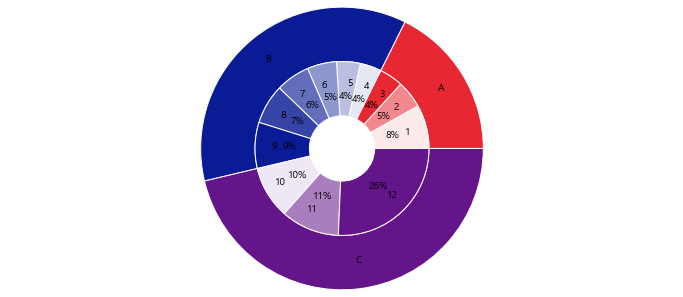

In [56]:
fig, ax = plt.subplots(figsize=(12,5))

ax.axis('equal')

pie_outside, _ = ax.pie(group_size, radius=1.3, 
                        labels=group_name, 
                        labeldistance=0.8,
                        colors=color_list)
plt.setp(pie_outside, 
         width=0.5, 
         edgecolor='white')
# Inside Ring

pie_inside, plt_labels, junk = \
    ax.pie(subgroup_size, 
           radius=(1.3 - 0.5), 
           labels=subgroup_name, 
           labeldistance=0.75, 
           autopct='%1.f%%',
           colors=sub_color_list)
plt.setp(pie_inside, 
         width=0.5, 
         edgecolor='white')
plt.title('', fontsize=20)
plt.show()

In [57]:
first=list(data_2.query('month==1').cust.unique())

In [58]:
c_c=[]
for i in range(1,13):
    c_c.append(len(set(data_2.query('month==@i').cust.unique()) & set(first)))
    first=set(data_2.query('month==@i').cust.unique()) & set(first)

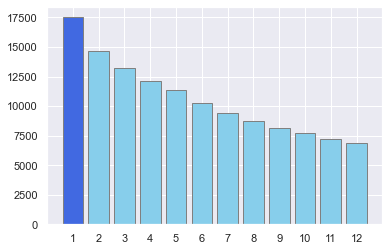

In [59]:
sns.set(style='darkgrid')
plt.bar(['1','2','3','4','5','6','7','8','9','10','11','12'],c_c,
       color=["royalblue"]+['skyblue']*11, edgecolor="gray")
plt.show()

In [60]:
del data_2["month"]

- 외부 데이터 특징 확인

In [61]:
opop=data_2.groupby("de_dt").agg({"cust":"nunique","평균기온(℃)":"mean", "최저기온(℃)":"mean", "최고기온(℃)":"mean", "강수량(mm)":"mean"})

In [62]:
data_2_eda = data_2.copy()
Metro_lst = ['Z10', 'Z17']
data_2_eda["zon_hlv"]=data_2_eda["zon_hlv"].apply(lambda x: '수도권' if x in Metro_lst else '비수도권')
data_2_eda = pd.DataFrame(data_2_eda.groupby('zon_hlv')['buy_am'].sum()/data_2_eda.groupby('zon_hlv')['buy_ct'].sum())
data_2["city"]=data_2["zon_hlv"].apply(lambda x: 1 if x in Metro_lst else 0)
data_2_eda.columns = ['평균구매금액']

In [63]:
opop["일교차"]=opop["최고기온(℃)"]-opop["최저기온(℃)"]

In [64]:
data_2_eda

,평균구매금액
zon_hlv,
비수도권,16834.774209
수도권,18448.961961


In [65]:
opop.columns[1:].to_list()

['평균기온(℃)', '최저기온(℃)', '최고기온(℃)', '강수량(mm)', '일교차']

C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8451 (\N{DEGREE CELSIUS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-p

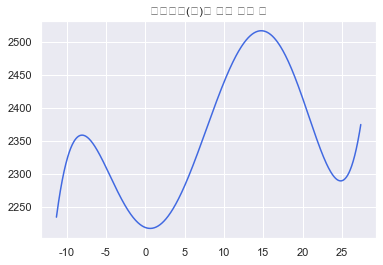

C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51200 (\N{HANGUL SYLLABLE JEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8451 (\N{DEGREE CELSIUS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packa

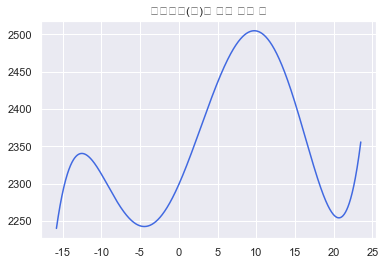

C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8451 (\N{DEGREE CELSIUS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packag

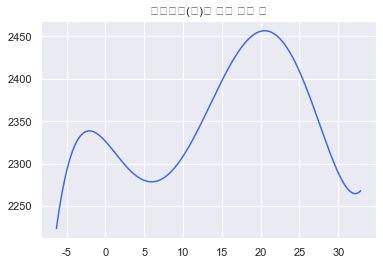

C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib

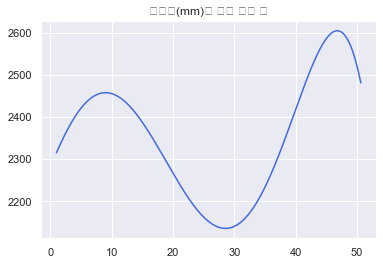

C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\lib\sit

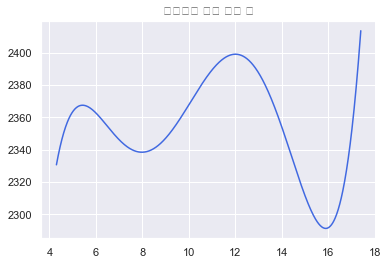

In [66]:
for a in opop.columns[1:].to_list():
    olol=opop.groupby(a)["cust"].mean().reset_index()
    poly = np.polyfit(olol[a], olol["cust"], 5) # 5차, 4차,.. 상수항 계수가 순서대로 들어있는 배열
    x_line = np.linspace(olol[a].min()+1, olol[a].max()-1, 1000) # 곡선을 완만하게 그리기 위한 linspace 객체 선언
    y_pred = x_line ** 5 * poly[0] + x_line ** 4 * poly[1] + x_line ** 3 * poly[2] + x_line ** 2 * poly[3] + x_line ** 1 * poly[4] + poly[5]
    plt.title(str(a) +"별 고객 방문 수")
    plt.plot(x_line, y_pred, color = 'royalblue')
    plt.show()

### 달 설정

In [67]:
train_mt_prev=int('2021'+input("data 이용 기간 설정  입력 예시   3월 이후 -> 03    : ")+'01')
train_mt_after=int('2021'+input("data 이용 기간 설정  입력 예시   9월 이전 -> 09      :")+'31')
data_2=data_2.query("de_dt<=@train_mt_after & de_dt>=@train_mt_prev")
data_3=data_3.query("de_dt<=@train_mt_after & de_dt>=@train_mt_prev")
data_6=data_6.query("de_dt<=@train_mt_after & de_dt>=@train_mt_prev")

data 이용 기간 설정  입력 예시   3월 이후 -> 03    : 12
data 이용 기간 설정  입력 예시   9월 이전 -> 09      :12


### 고객 별 선호하는 제품 및 제휴사 고객 별 특징 파악 - 주 선호하는 구매시간, 이용시간, 물품 종류, 제휴사, 점포

In [68]:
features = []

- 총구매액, 구매건수, 평균구매액, 최대구매액, 최소구매액

In [69]:
f = data_2.groupby('cust')['buy_am'].agg([('총구매액', np.sum),
                                            ('구매건수', np.size),
                                            ('평균구매액', lambda x : np.round(np.mean(x))),
                                            ('최대구매액', np.max),
                                            ('최소구매액', np.min)]).reset_index()

features.append(f)

- 주말방문비율, 주중방문비율

In [70]:
data_2['de_dt']= data_2['de_dt'].astype('str')
data_2['de_dt'] = pd.to_datetime(data_2['de_dt'])

C:\Users\User\AppData\Local\Temp\ipykernel_16020\4020781183.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['de_dt']= data_2['de_dt'].astype('str')
C:\Users\User\AppData\Local\Temp\ipykernel_16020\4020781183.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['de_dt'] = pd.to_datetime(data_2['de_dt'])


In [71]:
data_2['sales_dayofweek'] = data_2['de_dt'].dt.day_name()

day = {'Monday' : 0 , 'Tuesday' : 1 , 'Wednesday' : 2 , 'Thursday' : 3 , 'Friday' : 4 , 'Saturday': 5 , 'Sunday' : 6 }

data_2['sales_dayofweek_num'] = data_2['sales_dayofweek'].apply(lambda x : day[x] )

f = data_2.groupby('cust')['sales_dayofweek_num'].agg([
    ('주말방문비율', lambda x: np.mean(x >4)),
    ('주중방문비율' , lambda x : np.mean(x<5))
]).reset_index()

features.append(f)

C:\Users\User\AppData\Local\Temp\ipykernel_16020\1593635759.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['sales_dayofweek'] = data_2['de_dt'].dt.day_name()
C:\Users\User\AppData\Local\Temp\ipykernel_16020\1593635759.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['sales_dayofweek_num'] = data_2['sales_dayofweek'].apply(lambda x : day[x] )


- 계절방문비율

In [72]:
data_2['sales_month'] = data_2['de_dt'].dt.month
#
#f = data_2.groupby('cust')['sales_month'].agg([
#    ('봄-구매비율', lambda x: np.mean( x.isin([3,4,5]))),
#    ('여름-구매비율', lambda x: np.mean( x.isin([6,7,8]))),
#    ('가을-구매비율', lambda x: np.mean(x.isin([9,10,11]))),
#    ('겨울-구매비율', lambda x: np.mean( x.isin([1,2,12])))
#]).reset_index()
#
#features.append(f)

C:\Users\User\AppData\Local\Temp\ipykernel_16020\2845867494.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['sales_month'] = data_2['de_dt'].dt.month


- [월별] 총구매액, 구매건수, 평균구매액, 최대구매액, 최소구매액

In [73]:
#f = pd.pivot_table(data_2,index='cust',columns='sales_month',values='buy_am',aggfunc = ['sum','size','mean','max','min'],fill_value=0).reset_index()

#features.append(f)

- 시간대별방문비율 : 아침, 점심, 저녁으로 구분
- 0-5시는 새벽, 5-9시는 아침, 9-17시는 낮, 17-21시는 저녁, 21-24시는 밤

In [74]:
f = data_2.groupby('cust')['de_hr'].agg([
    ('새벽-구매비율', lambda x: np.mean( x.isin([0,1,2,3,4]))),
    ('아침-구매비율', lambda x: np.mean( x.isin([5,6,7,8]))),
    ('낮-구매비율', lambda x: np.mean( x.isin([9,10,11,12,13,14,15,16]))),
    ('저녁-구매비율', lambda x: np.mean( x.isin([17,18,19,20]))),
    ('밤-구매비율', lambda x: np.mean(x.isin([21,22,23])))
]).reset_index()

features.append(f)

- 온,오프라인 구매 비율(1: 오프라인, 2: 온라인)

In [75]:
f = data_2.groupby('cust')['chnl_dv'].agg([
    ('오프라인구매비율', lambda x: np.mean( x==1)),
    ('온라인구매비율', lambda x: np.mean( x==2))
]).reset_index()

features.append(f)

- 내점일수, 구매주기

In [76]:
data_2['sales_day'] = data_2['de_dt'].dt.day

C:\Users\User\AppData\Local\Temp\ipykernel_16020\2482336465.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['sales_day'] = data_2['de_dt'].dt.day


In [77]:
data_2['sales_date'] =data_2['sales_month'].astype(str).apply(lambda x : "0"+x if len(x) == 1  else x ) +data_2['sales_day'].astype(str).apply(lambda x : "0"+x if len(x) == 1 else  x )
data_2['sales_date'] = data_2['sales_date'].astype(int)

f = data_2.groupby('cust')['sales_date'].agg([
    ('내점일수',lambda x: x.nunique()),
    ('구매주기', lambda x: (x.max() - x.min()) / x.nunique())]).reset_index()

features.append(f)

C:\Users\User\AppData\Local\Temp\ipykernel_16020\3636558227.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['sales_date'] =data_2['sales_month'].astype(str).apply(lambda x : "0"+x if len(x) == 1  else x ) +data_2['sales_day'].astype(str).apply(lambda x : "0"+x if len(x) == 1 else  x )
C:\Users\User\AppData\Local\Temp\ipykernel_16020\3636558227.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['sales_date'] = data_2['sales_date'].astype(int)


- 주방문요일

In [78]:
f = data_2.groupby('cust')['sales_dayofweek'].agg([('주방문요일', lambda x: x.mode()[0])]).reset_index()
f = pd.get_dummies(f, columns=['주방문요일'])

features.append(f)

- 평균실구매액

In [81]:
data_2['real_amt'] = ( data_2['buy_am'] / data_2['buy_ct'] ).apply(lambda x : math.trunc(x)) 

f = data_2.groupby('cust')['real_amt'].agg([('평균실구매액', 'mean')]).reset_index()

features.append(f)

C:\Users\User\AppData\Local\Temp\ipykernel_16020\3477641688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['real_amt'] = ( data_2['buy_am'] / data_2['buy_ct'] ).apply(lambda x : math.trunc(x))


- 고가상품구매비율, 저가상품구매비율

In [82]:
buy_90 = data_2.buy_am.quantile(.90)
buy_10 = data_2.buy_am.quantile(.10)

f = data_2.groupby('cust')['buy_am'].agg([
    ('고가상품구매비율', lambda x: np.mean(x > buy_90 )),
    ('저가상품구매비율', lambda x: np.mean( x < buy_10 ))
]).reset_index()

features.append(f)

- 주구매지역

In [83]:
f = data_2.groupby('cust')['zon_hlv'].agg([('주구매지역', lambda x: x.value_counts().index[0])]).reset_index()
f = pd.get_dummies(f, columns=['주구매지역'])

features.append(f) ;f.head()

,cust,주구매지역_Z01,주구매지역_Z02,주구매지역_Z03,주구매지역_Z04,주구매지역_Z05,주구매지역_Z06,주구매지역_Z07,주구매지역_Z08,주구매지역_Z09,주구매지역_Z10,주구매지역_Z11,주구매지역_Z12,주구매지역_Z13,주구매지역_Z14,주구매지역_Z15,주구매지역_Z16,주구매지역_Z17
0,M000034966,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,M000136117,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,M000225114,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,M000261625,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,M000350564,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


- 주구매제휴사

In [84]:
f = data_2.groupby('cust')['cop_c'].agg([('주구매제휴사', lambda x: x.value_counts().index[0])]).reset_index()
f = pd.get_dummies(f, columns=['주구매제휴사'])

features.append(f) ;f.head()

,cust,주구매제휴사_A01,주구매제휴사_A02,주구매제휴사_A03,주구매제휴사_A04,주구매제휴사_A05,주구매제휴사_A06
0,M000034966,0,1,0,0,0,0
1,M000136117,1,0,0,0,0,0
2,M000225114,1,0,0,0,0,0
3,M000261625,1,0,0,0,0,0
4,M000350564,1,0,0,0,0,0


- 주구매지역

In [85]:
f = data_2.groupby('cust')['zon_hlv'].agg([('주구매지역', lambda x: x.value_counts().index[0])]).reset_index()
f = pd.get_dummies(f, columns=['주구매지역'])

features.append(f) ;f.head()

,cust,주구매지역_Z01,주구매지역_Z02,주구매지역_Z03,주구매지역_Z04,주구매지역_Z05,주구매지역_Z06,주구매지역_Z07,주구매지역_Z08,주구매지역_Z09,주구매지역_Z10,주구매지역_Z11,주구매지역_Z12,주구매지역_Z13,주구매지역_Z14,주구매지역_Z15,주구매지역_Z16,주구매지역_Z17
0,M000034966,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,M000136117,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,M000225114,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,M000261625,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,M000350564,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


- 주구매제휴사

In [86]:
f = data_2.groupby('cust')['cop_c'].agg([('주구매제휴사', lambda x: x.value_counts().index[0])]).reset_index()
f = pd.get_dummies(f, columns=['주구매제휴사'])

features.append(f) ;f.head()

,cust,주구매제휴사_A01,주구매제휴사_A02,주구매제휴사_A03,주구매제휴사_A04,주구매제휴사_A05,주구매제휴사_A06
0,M000034966,0,1,0,0,0,0
1,M000136117,1,0,0,0,0,0
2,M000225114,1,0,0,0,0,0
3,M000261625,1,0,0,0,0,0
4,M000350564,1,0,0,0,0,0


- 평균구매시간 , 총구매시간

In [87]:
data_2['total_sec'] = data_2['de_hr'].apply(lambda x : x//100*60 + x%100 )

C:\Users\User\AppData\Local\Temp\ipykernel_16020\2238629704.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['total_sec'] = data_2['de_hr'].apply(lambda x : x//100*60 + x%100 )


In [88]:
f = data_2.groupby('cust')['total_sec'].agg([
    ('평균쇼핑시간', lambda x: (x.max() - x.min()) / x.nunique()),
    ('총쇼핑시간' , 'sum')]).reset_index()

features.append(f) ;f.head()

,cust,평균쇼핑시간,총쇼핑시간
0,M000034966,0.00,152
1,M000136117,1.25,163
2,M000225114,1.00,162
3,M000261625,0.50,25
4,M000350564,0.00,16


- 구매요일다양성

In [89]:
a = data_2.sales_dayofweek.nunique()
f = data_2.groupby('cust')['sales_dayofweek'].agg([('구매요일다양성', lambda x: len(x.unique()) / a)]).reset_index()
features.append(f) ;f.head()

,cust,구매요일다양성
0,M000034966,0.142857
1,M000136117,0.571429
2,M000225114,0.428571
3,M000261625,0.142857
4,M000350564,0.142857


- 구매제휴사다양성

In [90]:
a = data_2.cop_c.nunique()
f = data_2.groupby('cust')['cop_c'].agg([('구매제휴사다양성', lambda x: len(x.unique()) / a)]).reset_index()
features.append(f); f.head()

,cust,구매제휴사다양성
0,M000034966,0.166667
1,M000136117,0.333333
2,M000225114,0.166667
3,M000261625,0.166667
4,M000350564,0.166667


- 구매점포다양성

In [91]:
a = data_2.br_c.nunique()
f = data_2.groupby('cust')['br_c'].agg([('구매점포다양성', lambda x: len(x.unique()) / a)]).reset_index()
features.append(f); f.head()

,cust,구매점포다양성
0,M000034966,0.000321
1,M000136117,0.000962
2,M000225114,0.000321
3,M000261625,0.000321
4,M000350564,0.000321


- 구매지역다양성

In [92]:
a = data_2.zon_hlv.nunique()
f = data_2.groupby('cust')['zon_hlv'].agg([('구매지역다양성', lambda x: len(x.unique()) / a)]).reset_index()
features.append(f) ;f.head()

,cust,구매지역다양성
0,M000034966,0.058824
1,M000136117,0.058824
2,M000225114,0.058824
3,M000261625,0.058824
4,M000350564,0.058824


- 구매상품소분류다양성

In [93]:
a = data_2.pd_nm.nunique()
f = data_2.groupby('cust')['pd_nm'].agg([('구매상품소분류', lambda x: len(x.unique()) / a)]).reset_index()
features.append(f) ;f.head()

,cust,구매상품소분류
0,M000034966,0.003634
1,M000136117,0.004240
2,M000225114,0.005451
3,M000261625,0.001211
4,M000350564,0.000606


- 주구매상품중분류다양성

In [94]:
a = data_2.clac_hlv_nm.nunique()
f = data_2.groupby('cust')['clac_hlv_nm'].agg([('주구매상품중분류', lambda x: len(x.unique()) / a)]).reset_index()
features.append(f) ;f.head()

,cust,주구매상품중분류
0,M000034966,0.051724
1,M000136117,0.103448
2,M000225114,0.137931
3,M000261625,0.034483
4,M000350564,0.017241


- 주구매상품대분류다양성

In [95]:
a = data_2.clac_mcls_nm.nunique()
f = data_2.groupby('cust')['clac_mcls_nm'].agg([('구매지역다양성', lambda x: len(x.unique()) / a)]).reset_index()
features.append(f); f.head()

,cust,구매지역다양성
0,M000034966,0.011940
1,M000136117,0.020896
2,M000225114,0.026866
3,M000261625,0.005970
4,M000350564,0.002985


- 이벤트성 고객 (총 구매횟수가 1번인 고객)

In [96]:
f = data_2.groupby('cust')['de_dt'].agg([('n_date', 'nunique')]).reset_index()
f['one_visit'] = f['n_date'].apply(lambda x: 1 if x<2 else 0)

features.append(f) ;f.head()

,cust,n_date,one_visit
0,M000034966,1,1
1,M000136117,4,0
2,M000225114,3,0
3,M000261625,1,1
4,M000350564,1,1


In [97]:
len(features)

21

In [100]:
data = features[0]
for f in tqdm(features[1:]):
    data = pd.merge(data, f, on = 'cust', how="left")

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 43.79it/s]


In [101]:
data = pd.merge(data, data_6_f, how='left',on='cust')

In [102]:
# 마지막날짜부터 365일전까지 (14일씩 26번) 매주 구매건수를 계산하여 리스트에 넣음
week_to = data_2.de_dt.max()
week_trans = []
for i in range(4):
    week_from = week_to + pd.DateOffset(weeks=-1)
    week_trans.append(data_2.query('@week_from < de_dt <= @week_to')
                      .groupby('cust')['de_dt']
                      .agg([(f'w{4-i}', 'count')])
                      .reset_index())
    week_to = week_from

# 리스트로부터 데이터프레임 변환 
f = pd.DataFrame({'cust': data_2.cust.unique()})
for w in week_trans[::-1]:
    f = pd.merge(f, w, how='left')
f = f.fillna(0)
f.head()

,cust,w1,w2,w3,w4
0,M633699032,9.0,7.0,15.0,13.0
1,M854194558,7.0,6.0,7.0,8.0
2,M922355728,0.0,0.0,0.0,0.0
3,M146192942,20.0,2.0,27.0,10.0
4,M711726125,13.0,8.0,4.0,13.0


In [103]:
k = np.polyfit(range(4),f.iloc[:,1:].T,1)[0]

In [104]:
data_df = pd.DataFrame(k, index=f.cust, columns=['w'])
data_df =data_df.reset_index()

In [105]:
data = pd.merge(data,data_df,how='left')

- 연령대별 유통사 선호도에 따른 가중치

In [106]:
data_2['age'] = pd.to_numeric(data_2['ages'].str[:2])

C:\Users\User\AppData\Local\Temp\ipykernel_16020\956866508.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['age'] = pd.to_numeric(data_2['ages'].str[:2])


In [107]:
data_2['age_group'] = data_2['age'].apply(lambda x : 'twenty' if (x>=20) & (x<30)
                                     else 'thirty' if (x>=30) & (x<40)
                                     else 'forty' if (x>=40) & (x<50)
                                     else 'fifty' if (x>=50) & (x<60)
                                     else 'sixty' if (x>=60) & (x<70)                                          
                                     else 'seventy')

twenty_prefer_brd = data_2[data_2['age_group'] == 'twenty'].cop_c.value_counts().index[1:].to_list()
thirty_prefer_brd = data_2[data_2['age_group'] == 'thirty'].cop_c.value_counts().index[1:].to_list()
forty_prefer_brd = data_2[data_2['age_group'] == 'forty'].cop_c.value_counts().index[1:].to_list()
fifty_prefer_brd = data_2[data_2['age_group'] == 'fifty'].cop_c.value_counts().index[1:].to_list()
sixty_prefer_brd = data_2[data_2['age_group'] == 'sixty'].cop_c.value_counts().index[1:].to_list()
seventy_prefer_brd = data_2[data_2['age_group'] == 'seventy'].cop_c.value_counts().index[1:].to_list()

def prefer_brd(x, list):
    for i in range(len(list)):
        if(x == list[i]):
            return len(list)-i

data_2['20_weight_cop'] = data_2['cop_c'].apply(lambda x: prefer_brd(x, twenty_prefer_brd)).fillna(0)
data_2['30_weight_cop'] = data_2['cop_c'].apply(lambda x: prefer_brd(x, thirty_prefer_brd)).fillna(0)
data_2['40_weight_cop'] = data_2['cop_c'].apply(lambda x: prefer_brd(x, forty_prefer_brd)).fillna(0)
data_2['50_weight_cop'] = data_2['cop_c'].apply(lambda x: prefer_brd(x, fifty_prefer_brd)).fillna(0)
data_2['60_weight_cop'] = data_2['cop_c'].apply(lambda x: prefer_brd(x, sixty_prefer_brd)).fillna(0)
data_2['70_weight_cop'] = data_2['cop_c'].apply(lambda x: prefer_brd(x, seventy_prefer_brd)).fillna(0)

data_2['weight_sum'] = data_2['20_weight_cop'] + data_2['30_weight_cop'] + data_2['40_weight_cop'] + data_2['50_weight_cop'] + data_2['60_weight_cop'] + data_2['70_weight_cop']

C:\Users\User\AppData\Local\Temp\ipykernel_16020\922604343.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['age_group'] = data_2['age'].apply(lambda x : 'twenty' if (x>=20) & (x<30)
C:\Users\User\AppData\Local\Temp\ipykernel_16020\922604343.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['20_weight_cop'] = data_2['cop_c'].apply(lambda x: prefer_brd(x, twenty_prefer_brd)).fillna(0)
C:\Users\User\AppData\Local\Temp\ipykernel_16020\922604343.py:21: SettingWithCopyWarning: 
A value is try

In [108]:
f = data_2.groupby('cust')['20_weight_cop', '30_weight_cop', '40_weight_cop', '50_weight_cop', '60_weight_cop', '70_weight_cop', 'weight_sum'].sum()

f['20_weight_cop'] = f['20_weight_cop'] / f['weight_sum']
f['30_weight_cop'] = f['30_weight_cop'] / f['weight_sum'] 
f['40_weight_cop'] = f['40_weight_cop'] / f['weight_sum'] 
f['50_weight_cop'] = f['50_weight_cop'] / f['weight_sum']
f['60_weight_cop'] = f['60_weight_cop'] / f['weight_sum']
f['70_weight_cop'] = f['70_weight_cop'] / f['weight_sum']
f.drop(columns='weight_sum', inplace = True)

f = f.fillna(0)
features.append(f) ;f.head()

C:\Users\User\AppData\Local\Temp\ipykernel_16020\1901620322.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  f = data_2.groupby('cust')['20_weight_cop', '30_weight_cop', '40_weight_cop', '50_weight_cop', '60_weight_cop', '70_weight_cop', 'weight_sum'].sum()


,20_weight_cop,30_weight_cop,40_weight_cop,50_weight_cop,60_weight_cop,70_weight_cop
cust,,,,,,
M000034966,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
M000136117,0.191837,0.191837,0.155102,0.155102,0.155102,0.151020
M000225114,0.192308,0.192308,0.153846,0.153846,0.153846,0.153846
M000261625,0.192308,0.192308,0.153846,0.153846,0.153846,0.153846
M000350564,0.192308,0.192308,0.153846,0.153846,0.153846,0.153846


In [109]:
f = f.reset_index()

In [110]:
data = pd.merge(data,f,how = 'left')

In [111]:
train_data = list(data_2.groupby('cust')['clac_hlv_nm'].unique())
train_data

[array(['과자', '원예/애완', '완구'], dtype=object),
 array(['속옷/양말/홈웨어', '아웃도어/레저', '유아동의류', '남성의류', '패션잡화', '여성의류'],
       dtype=object),
 array(['축산물', '수산물', '채소', '음료', '과일', '조리식품', '테넌트/음식점', '과자'],
       dtype=object),
 array(['화장품/뷰티케어', '테넌트/음식점'], dtype=object),
 array(['화장품/뷰티케어'], dtype=object),
 array(['음료', '테넌트/음식점', '커피/차', '유아식품'], dtype=object),
 array(['아웃도어/레저', '테넌트/음식점', '유아동의류', '주방잡화', '냉장식품', '청소/세탁/욕실용품',
        '조리식품', '채소', '음료', '대용식', '주류', '축산물', '유제품', '과자', '수산물'],
       dtype=object),
 array(['퍼스널케어', '화장품/뷰티케어', '속옷/양말/홈웨어', '청소/세탁/욕실용품', '과자'], dtype=object),
 array(['주류', '과자', '청소/세탁/욕실용품', '음료', '세제/위생', '대용식', '테넌트/음식점'],
       dtype=object),
 array(['과자', '패션잡화', '스포츠패션', '음료', '조리식품', '병통조림', '채소', '축산물', '여성의류',
        '냉장식품', '수산물', '유제품', '냉장/세탁가전', '테넌트/음식점', '영상/음향가전', '대용식',
        '침구/수예', '남성의류', '과일', '유아동의류'], dtype=object),
 array(['패션잡화'], dtype=object),
 array(['기타(비상품)', '조리식품', '대용식', '냉장식품', '주류'], dtype=object),
 array(['완구'], 

In [112]:
def oversample(x, n):
    lst = []
    for i in x:
        tmp = []
        for j in range(n):
          random.shuffle(i)
          tmp += list(i)
        lst.append(tmp)
    return lst

In [113]:
w2v_input = oversample(train_data, 10)

In [114]:
w2v = word2vec.Word2Vec(sentences = w2v_input,
                        vector_size = 20, #단어 벡터의 크기
                        window = 3, #주변단어개수
                        min_count = 1, #전체 문서에 등장한 최소 개수
                        sg = 1).wv # sg : Training algorithm: 1 for skip-gram; otherwise CBOW.

In [115]:
train_mean_vector = []
from tqdm import tqdm
for words in tqdm(train_data):
        tmp = np.zeros(20)             # 다음 customer ID에 대한 vector를 계삲하기 전 0으로 초기화
        cnt = 0
        for word in words:
            try:
                tmp += w2v[word]
                cnt += 1
            except:
                pass
        tmp /= cnt                      # customer ID 에 있는 아이템 갯수로 전체 벡터를 mean해줌  
        train_mean_vector.append(tmp)
        
train_mean_vector = np.array(train_mean_vector)

100%|█████████████████████████████████████████████████████████████████████████| 17828/17828 [00:01<00:00, 17617.06it/s]


In [116]:
pd.DataFrame(train_mean_vector).isna().sum().sum()

0

In [117]:
train_mean_vector

array([[-0.10702269,  0.57612619, -0.33444168, ..., -0.11064715,
        -0.45142043,  0.00609578],
       [-0.29295155,  0.36142047, -0.06339594, ...,  0.43786252,
        -0.20882031, -0.136837  ],
       [-0.0584115 ,  0.46672782, -0.20510076, ..., -0.22665389,
        -0.02625527, -0.16442748],
       ...,
       [-0.02492149,  0.3034872 ,  0.01229164, ..., -0.32954643,
        -0.14908179, -0.08949687],
       [-0.08627189,  0.50131181, -0.22205167, ..., -0.26622245,
        -0.14007681, -0.23369843],
       [-0.01639615,  0.46263728, -0.11797564, ..., -0.13551246,
        -0.21731451, -0.17258776]])

In [118]:
train_mean_vector = pd.DataFrame(train_mean_vector)
train_mean_vector.columns = train_mean_vector.columns.astype(str) + 'clac_hlv_nm'

In [119]:
train_mean_vector

,0clac_hlv_nm,1clac_hlv_nm,2clac_hlv_nm,3clac_hlv_nm,4clac_hlv_nm,5clac_hlv_nm,6clac_hlv_nm,7clac_hlv_nm,8clac_hlv_nm,9clac_hlv_nm,10clac_hlv_nm,11clac_hlv_nm,12clac_hlv_nm,13clac_hlv_nm,14clac_hlv_nm,15clac_hlv_nm,16clac_hlv_nm,17clac_hlv_nm,18clac_hlv_nm,19clac_hlv_nm
0,-0.107023,0.576126,-0.334442,-0.326635,0.002383,-0.218355,-0.107364,0.146691,-0.314892,0.026435,-0.188738,-0.140404,0.260604,-0.019890,-0.200808,-0.211474,-0.093692,-0.110647,-0.451420,0.006096
1,-0.292952,0.361420,-0.063396,-0.106650,-0.226212,-0.197243,0.412337,0.266157,0.123056,0.070992,-0.185109,-0.035108,0.407036,0.185504,0.118151,-0.069656,-0.074639,0.437863,-0.208820,-0.136837
2,-0.058411,0.466728,-0.205101,-0.206637,0.107747,0.032437,0.199432,0.035966,0.007232,-0.142935,-0.366756,-0.162873,0.375098,0.043643,-0.189306,-0.224994,-0.300279,-0.226654,-0.026255,-0.164427
3,0.238233,0.360020,0.115890,-0.256223,-0.015880,-0.292953,0.355457,0.000018,0.070800,-0.088936,-0.101260,-0.387382,0.534640,-0.080565,0.103763,0.099148,0.013029,0.045221,0.151640,-0.408696
4,0.401681,0.096862,0.260602,-0.432024,0.119760,-0.511346,0.438846,-0.052693,0.200443,-0.154320,-0.112030,-0.442057,0.477254,-0.287129,0.123751,0.148380,-0.258318,0.249240,0.145244,-0.677443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17823,-0.020543,0.482780,-0.212149,-0.292255,0.162128,-0.062773,0.123289,0.024558,-0.023084,-0.036294,-0.396726,-0.132502,0.262013,0.127737,-0.171738,-0.227698,-0.398800,-0.263856,-0.209851,-0.132476
17824,-0.245841,0.540881,-0.348631,-0.307487,0.026265,0.126283,0.213180,0.061493,0.177013,0.086308,-0.169159,-0.271623,0.225779,0.039337,-0.311678,-0.113889,-0.013043,-0.155046,-0.029706,-0.268623
17825,-0.024921,0.303487,0.012292,-0.504262,0.200787,0.073889,0.192914,0.139784,0.181926,0.137413,-0.445524,-0.241157,0.320963,-0.033265,-0.284999,-0.158888,-0.209918,-0.329546,-0.149082,-0.089497
17826,-0.086272,0.501312,-0.222052,-0.119458,0.163973,-0.029498,0.132142,-0.010888,-0.054052,0.019771,-0.483730,-0.089097,0.263088,0.171259,-0.147008,-0.210368,-0.530892,-0.266222,-0.140077,-0.233698


In [120]:
data = pd.concat([data, train_mean_vector], axis=1)

In [121]:
data

,cust,총구매액,구매건수,평균구매액,최대구매액,최소구매액,주말방문비율,주중방문비율,새벽-구매비율,아침-구매비율,...,10clac_hlv_nm,11clac_hlv_nm,12clac_hlv_nm,13clac_hlv_nm,14clac_hlv_nm,15clac_hlv_nm,16clac_hlv_nm,17clac_hlv_nm,18clac_hlv_nm,19clac_hlv_nm
0,M000034966,90700.0,8,11338.0,39900.0,1200.0,0.000000,1.000000,0.000000,0.00,...,-0.188738,-0.140404,0.260604,-0.019890,-0.200808,-0.211474,-0.093692,-0.110647,-0.451420,0.006096
1,M000136117,1493300.0,10,149330.0,924000.0,100.0,0.500000,0.500000,0.000000,0.00,...,-0.185109,-0.035108,0.407036,0.185504,0.118151,-0.069656,-0.074639,0.437863,-0.208820,-0.136837
2,M000225114,99800.0,9,11089.0,30000.0,5000.0,0.111111,0.888889,0.000000,0.00,...,-0.366756,-0.162873,0.375098,0.043643,-0.189306,-0.224994,-0.300279,-0.226654,-0.026255,-0.164427
3,M000261625,68000.0,2,34000.0,38000.0,30000.0,1.000000,0.000000,0.000000,0.00,...,-0.101260,-0.387382,0.534640,-0.080565,0.103763,0.099148,0.013029,0.045221,0.151640,-0.408696
4,M000350564,222000.0,1,222000.0,222000.0,222000.0,1.000000,0.000000,0.000000,0.00,...,-0.112030,-0.442057,0.477254,-0.287129,0.123751,0.148380,-0.258318,0.249240,0.145244,-0.677443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17823,M999515910,623335.0,50,12467.0,149900.0,790.0,1.000000,0.000000,0.000000,0.00,...,-0.396726,-0.132502,0.262013,0.127737,-0.171738,-0.227698,-0.398800,-0.263856,-0.209851,-0.132476
17824,M999673157,893570.0,11,81234.0,544600.0,50.0,0.272727,0.727273,0.363636,0.00,...,-0.169159,-0.271623,0.225779,0.039337,-0.311678,-0.113889,-0.013043,-0.155046,-0.029706,-0.268623
17825,M999770689,67400.0,12,5617.0,43000.0,1200.0,0.083333,0.916667,0.000000,0.75,...,-0.445524,-0.241157,0.320963,-0.033265,-0.284999,-0.158888,-0.209918,-0.329546,-0.149082,-0.089497
17826,M999849895,20990.0,4,5248.0,8480.0,3140.0,0.000000,1.000000,0.000000,0.00,...,-0.483730,-0.089097,0.263088,0.171259,-0.147008,-0.210368,-0.530892,-0.266222,-0.140077,-0.233698


In [ ]:
data.to_csv("data/data_12_12.csv", index=False)